Датасет: [MotionSense Dataset](https://github.com/mmalekzadeh/motion-sense)

Содержит показания с частотой 50Гц

Активности: downstairs, upstairs, walking, jogging, sitting, and standing
Данные: "attitude", "gravity", "rotationRate", "userAcceleration":

Поле **id** отвечает за номер человека, который производил активность.


Скачаем этот датасет:

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

drive.mount("/content/drive")

#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Скачивание и распаковка датасета.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']

In [ ]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=37)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(X_train.shape)

torch.Size([105, 4])


In [ ]:
!pip install geotorch -q

from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.7 MB/s eta 0:00:00


Архитектура: $4---128---3$. 

In [ ]:
in_len = 4
hid_dim = 128
out_len = 3

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)



train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cuda:0


In [ ]:
def train_one_epoch(model, optimizer, loader, criterion, device='cpu'):
    model.train()
    right_preds = 0
    total_preds = 0
    losses_tr = []

    for batch, y in loader:
        batch = batch.to(device)
        y = y.to(device)
        # batch = [batch_size, seq_len]

        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 

        preds = torch.argmax(out, dim=-1)

        right_preds += (preds == y).sum().item()
        total_preds += len(y)


    return model, optimizer, np.mean(losses_tr), right_preds / total_preds


def validate(model, loader, criterion, device='cpu'):
    model.eval()

    losses = []
    right_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch, y in loader:
            batch = batch.to(device)
            y = y.to(device)

            out = model(batch)
            loss = criterion(out, y)

            losses.append(loss.item())

            preds = torch.argmax(out, dim=-1)
            right_preds += (preds == y).sum().item()
            total_preds += len(y)
    
    return np.mean(losses), right_preds / total_preds


def learning_loop(model, 
                  optimizer, 
                  train_loader,
                  test_loader, 
                  criterion, 
                  scheduler=None, 
                  epochs=10, 
                  val_every=1, 
                  draw_every=1, 
                  tr_loss_avg_last=10,
                  separate_show=False, 
                  device='cpu'):
    losses = {'train': [], 'val': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs+1):
        # print(f'#{epoch}/{epochs}:')
        model, optimizer, loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion, device)
        losses['train'].append(loss)
        losses['train_acc'].append(tr_acc)
        

        if not (epoch % val_every):
            loss, v_acc = validate(model, test_loader, criterion, device)
            losses['val'].append(loss)
            losses['val_acc'].append(v_acc)
            if scheduler is not None:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(2, figsize=(12, 6))
            n_tr_l = np.mean(losses['train'][-tr_loss_avg_last:])
            v_l = losses['val'][-1]
            fig.suptitle(f'#{epoch}/{epochs}; tr_loss: {n_tr_l:.4f}; val_loss: {v_l:.4f}')

            plt.subplot(121)
            plt.plot(losses['train'], 'b.-', linewidth=2, label='train')
            plt.plot(losses['val'], '.-', color='orange', linewidth=2, label='val')

            plt.xlabel('epoch')
            plt.ylabel('mse')
            plt.legend()

            plt.subplot(122)
            plt.title('Accuracy')

            plt.plot(losses['train_acc'], '.-', color='blue', linewidth=2, label='train_acc')
            plt.plot(losses['val_acc'], '.-', color='orange', linewidth=2, label='val_acc')
            
            plt.xlabel('epoch', fontsize=18)
            plt.ylabel('Accuracy', fontsize=18)
            plt.legend()
            
            plt.show()
    
    return model, optimizer, losses


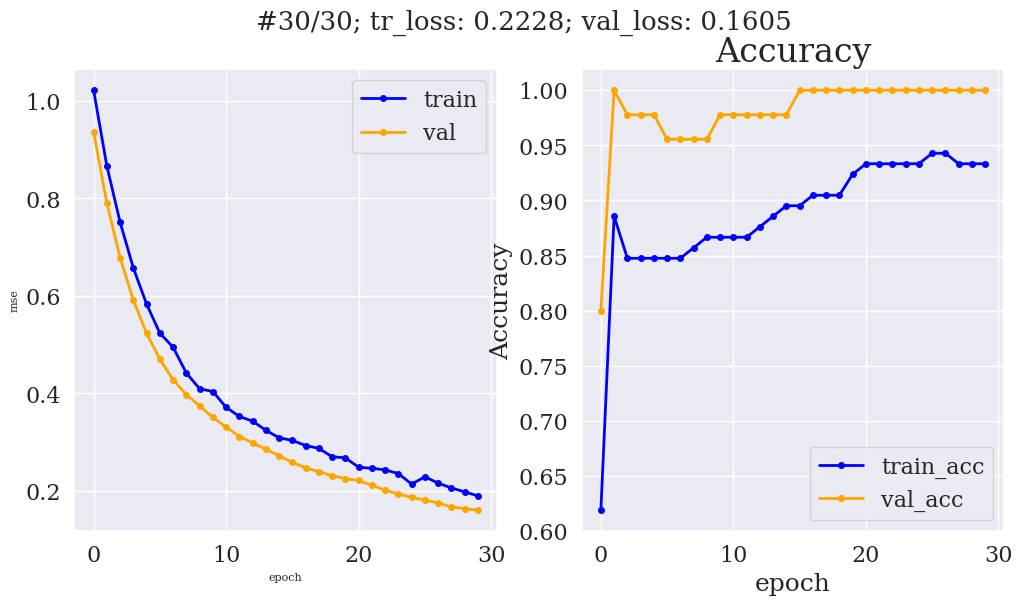

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = train_dataloader,
    test_loader = test_dataloader,
    criterion = criterion,
    epochs=30,
    draw_every=1,
    separate_show=False,
    device=device
)

Видим: 15 эпох достаточно для 100% точности на тесте

Теперь запустим обучение 100 моделей для оценки дисперсий/ковариаций.

In [ ]:
!rm -rf $path

In [ ]:
path = '/content/drive/MyDrive/metric_analysis/2NN_experiment_iris_4_100_3'
!mkdir $path # создание папка
N = 100
max_epochs = 15

In [ ]:
# Обучение моделей

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

    model, optimizer, losses_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        train_loader = train_dataloader,
        test_loader = test_dataloader,
        criterion = criterion,
        epochs=max_epochs,
        draw_every=max_epochs+1,
        val_every=max_epochs+1,
        separate_show=False,
        device=device
    )

    models.append(model)
    losses.append(losses_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [ ]:
# загрузка моделей

models = []

for i in range(1, N + 1):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    model.load_state_dict(torch.load(path + f'/nn_{i}.pth'))
    models.append(model)

Теперь на входном слое имеем 128 нейронов размерности 4.

Будем объединять одинаковые по **среднему**.

используем $W_1$

In [ ]:
W1_matrices = np.array([models[i].W1.weight.detach().cpu().numpy() for i in range(len(models))])
print(W1_matrices.shape)

means = W1_matrices.mean(axis=0)
variances = np.array([np.cov(W1_matrices[:, i, :], rowvar=False) for i in range(hid_dim)])
correlations = np.array([np.corrcoef(W1_matrices[:, i, :], rowvar=False) for i in range(hid_dim)])
print(means.shape, variances.shape)

(100, 128, 4)
(128, 4) (128, 4, 4)


In [ ]:
import copy

def estimate_quality(W1_weight):
    model_1 = copy.deepcopy(models[0])
    with torch.no_grad():
        model_1.W1.weight = W1_weight
    
    return validate(model_1, loader = test_dataloader,
        criterion = criterion, device=device)

Оценка качества.

In [ ]:
from sklearn.cluster import KMeans

def change_weights(W1weight, labels):
    '''
        labels: list with ints; We change weight of cluster as mean weight!
    '''
    with torch.no_grad():
        new_weights = copy.deepcopy(W1weight)

        unique_labels = np.unique(labels)

        for lab in unique_labels:
            new_weights[labels == lab, :] = new_weights[labels == lab, :].mean(axis=0, keepdims=True)
        
    return new_weights

In [ ]:
# проверка корректности
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(means)
new_weights = change_weights(models[0].W1.weight, kmeans.labels_)
estimate_quality(new_weights)[1]

0.26666666666666666

In [ ]:
# quality - точность предсказания
qualities = []

cluster_range = list(range(1, models[0].W1.weight.shape[0], 5))

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(means)

    new_weights = change_weights(models[0].W1.weight, kmeans.labels_)
    quality = estimate_quality(new_weights)[1]

    qualities.append(quality)
    print(f'clust: {n_clusters}, quality: {quality:.3f}')

clust: 1, quality: 0.267
clust: 6, quality: 0.267
clust: 11, quality: 0.267
clust: 16, quality: 0.311
clust: 21, quality: 0.267
clust: 26, quality: 0.289
clust: 31, quality: 0.333
clust: 36, quality: 0.533
clust: 41, quality: 0.578
clust: 46, quality: 0.622
clust: 51, quality: 0.667
clust: 56, quality: 0.733
clust: 61, quality: 0.667
clust: 66, quality: 0.867
clust: 71, quality: 0.889
clust: 76, quality: 0.844
clust: 81, quality: 0.844
clust: 86, quality: 0.889
clust: 91, quality: 0.933
clust: 96, quality: 0.911
clust: 101, quality: 0.978
clust: 106, quality: 0.978
clust: 111, quality: 0.978
clust: 116, quality: 0.978
clust: 121, quality: 0.978
clust: 126, quality: 0.978


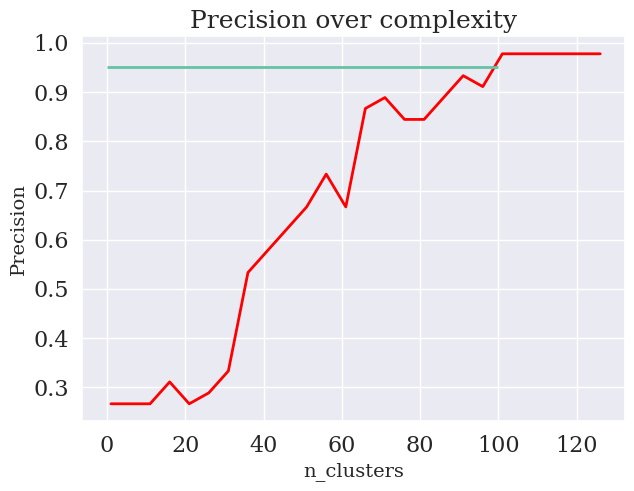

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, qualities, linewidth=2, c='r')
plt.title('Precision over complexity', fontsize=18)

plt.hlines(0.95, 0, 100)

plt.ylabel('Precision', fontsize=14)
plt.xlabel('n_clusters', fontsize=14);

Теперь используем ковариации и Wassershtine distance: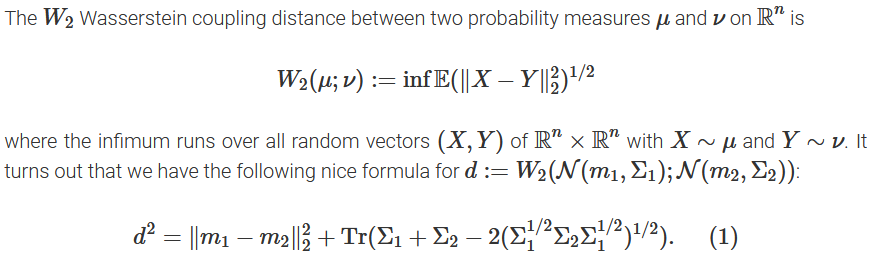

In [ ]:
class GaussianPoint:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

    def __len__(self):
        return len(self.mean)

In [ ]:
neural_dim = 4

In [ ]:
gau_points = [np.concatenate([means[i], variances[i].reshape(-1)]) for i in range(len(means))]

In [ ]:
from scipy.linalg import sqrtm

def get_wassershtine_distance(mu_1, Sigma_1, mu_2, Sigma_2):

    sqrt_Sigma_1 = sqrtm(Sigma_1)
    d_sq = np.sum((mu_1 - mu_2)**2) + np.trace(Sigma_1 + Sigma_2 - 2 * sqrtm(sqrt_Sigma_1 @ Sigma_2 @ sqrt_Sigma_1))
    
    if np.abs(d_sq) < 1e-7:
        d_sq = 0
    
    #assert d_sq >= 0, d_sq
    return np.sqrt(d_sq)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
!pip3 install pyclustering

In [ ]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [ ]:
user_function = lambda point1, point2: get_wassershtine_distance(point1[:neural_dim], point1[neural_dim:].reshape(neural_dim, neural_dim), point2[:neural_dim], point2[neural_dim:].reshape(neural_dim, neural_dim))
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

In [ ]:
n_clusters = 2

initial_centers = gau_points[:n_clusters]

kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)

In [ ]:
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

In [ ]:
labels = np.zeros(shape=models[0].W1.weight.shape[0])
for i, lst in enumerate(clusters):
    labels[lst] = i
print(labels)

[0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 0.]


In [ ]:
n_clusters = 8

initial_centers = gau_points[:n_clusters]
kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)

In [ ]:
kmeans_plusplus_initializer(gau_points, amount_centers=2).initialize()

In [ ]:
from tqdm.auto import tqdm
qualities_wass = []

cluster_range = list(range(2, models[0].W1.weight.shape[0], 5))

for n_clusters in tqdm(cluster_range):
    initial_centers = kmeans_plusplus_initializer(gau_points, amount_centers=n_clusters).initialize()
    kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)
    kmeans_instance.process()

    lab_list = kmeans_instance.get_clusters()
    # print(lab_list)
    labels = np.zeros(shape=models[0].W1.weight.shape[0])
    for i, lst in enumerate(lab_list):
        labels[lst] = i

    new_weights = change_weights(models[0].W1.weight, labels)
    quality = estimate_quality(new_weights)[1]

    qualities_wass.append(quality)
    print(f'clust: {n_clusters}, quality: {quality:.3f}')

  0%|          | 0/26 [00:00<?, ?it/s]

clust: 2, quality: 0.267
clust: 7, quality: 0.267
clust: 12, quality: 0.267
clust: 17, quality: 0.333
clust: 22, quality: 0.422
clust: 27, quality: 0.267
clust: 32, quality: 0.578
clust: 37, quality: 0.578
clust: 42, quality: 0.644
clust: 47, quality: 0.644
clust: 52, quality: 0.956
clust: 57, quality: 0.844
clust: 62, quality: 0.844
clust: 67, quality: 0.956
clust: 72, quality: 1.000
clust: 77, quality: 0.956
clust: 82, quality: 0.956
clust: 87, quality: 1.000
clust: 92, quality: 1.000
clust: 97, quality: 0.978
clust: 102, quality: 0.978
clust: 107, quality: 0.978
clust: 112, quality: 0.978
clust: 117, quality: 0.978
clust: 122, quality: 0.978
clust: 127, quality: 0.978


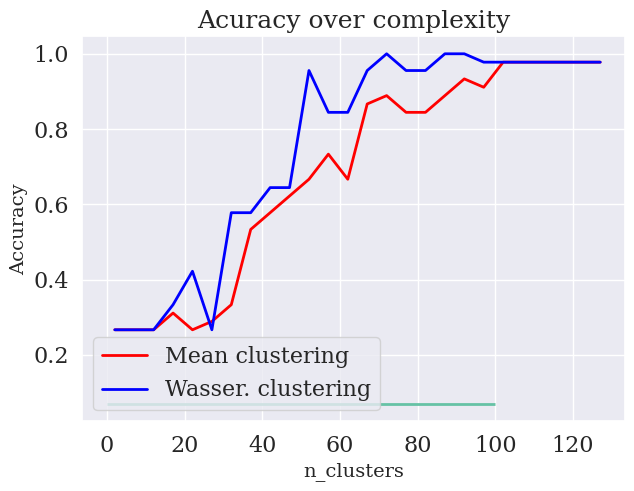

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, qualities, linewidth=2, c='r', label='Mean clustering')
plt.plot(cluster_range, qualities_wass, linewidth=2, c='b', label='Wasser. clustering')

plt.title('Acuracy over complexity', fontsize=18)

plt.hlines(0.07, 0, 100)

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('n_clusters', fontsize=14)
plt.legend();

лучше: ковариации не нужны.



#### 5. другой датасет: MNIST clasification

3-х слойная сеть: 784-10-100-10

In [ ]:
import torchvision
from torchvision import transforms
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

784

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_data[0][1]

5

In [ ]:
Другой датасет: win

In [ ]:
len(clusters)

2

Теперь визуализируем нейроны: у них очень малая дисперсия!!!

In [ ]:
import seaborn as sns

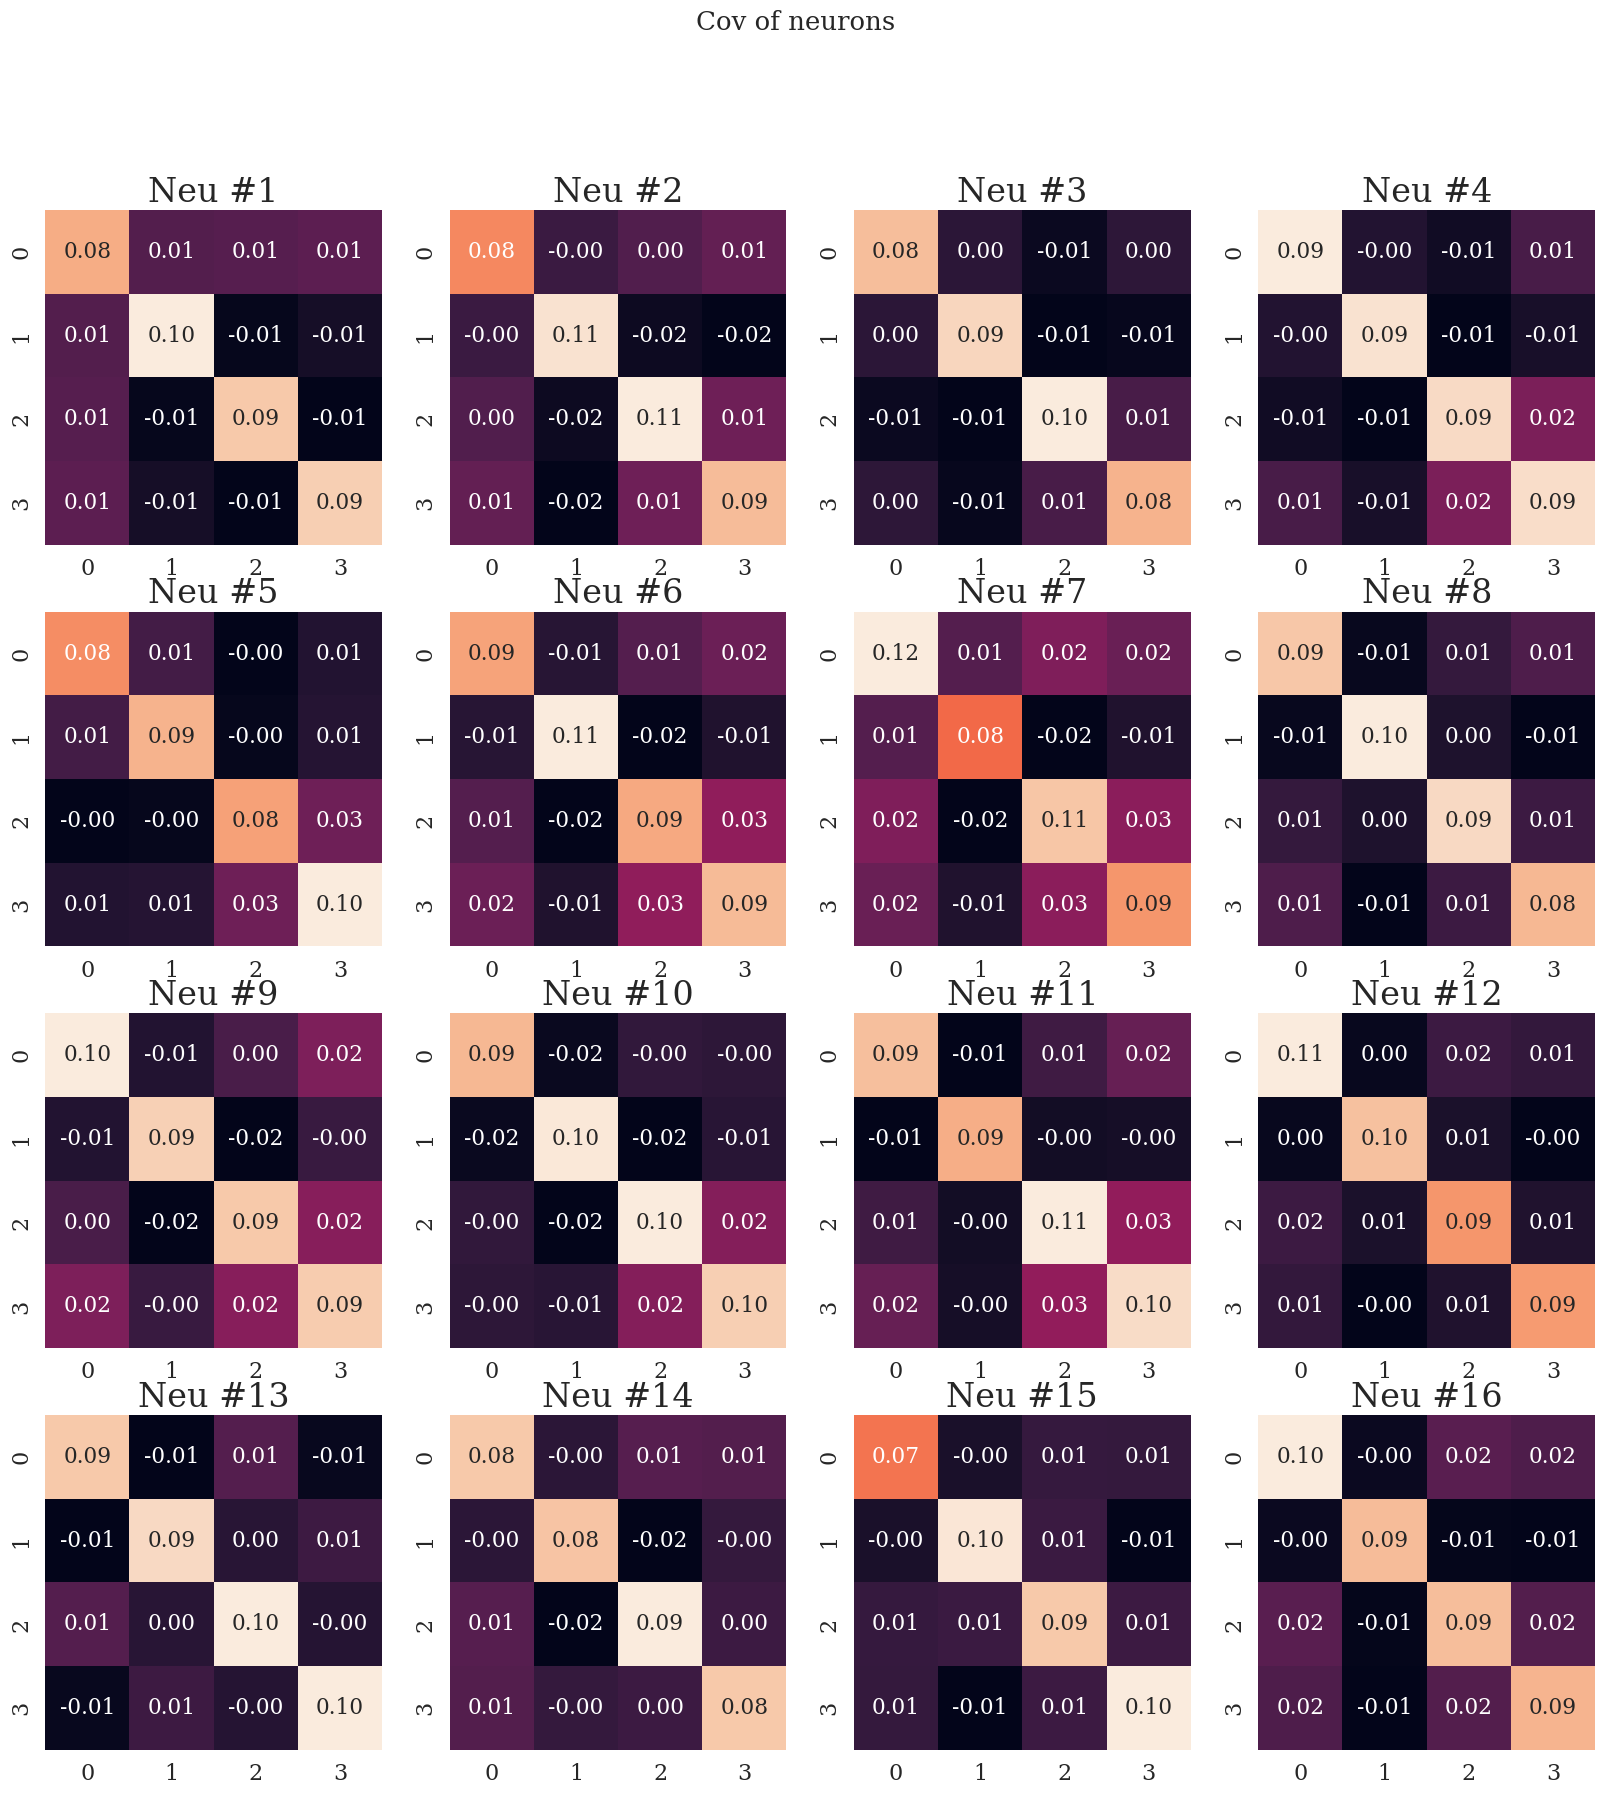

In [ ]:
plot_cov_heatmap(variances[:16])

Визуализация нейронов: хочу ИХ ВСЕ спроецировать на такое 3-х мерное пространство, где лучше всего!

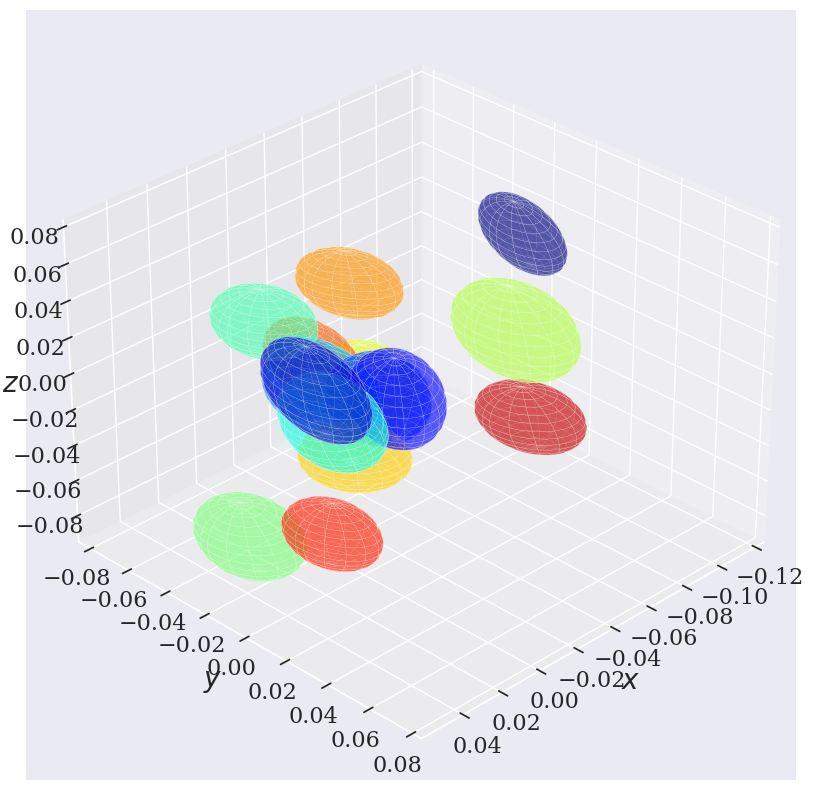

In [ ]:
plot_3d_gaussians(means[:, :3][:16], variances[:, :3, :3][:16], alpha=0.2)

In [ ]:
plot_3d_gaussians_rot(means[:, :3][:16], variances[:, :3, :3][:16], alpha=0.2)